dataset = https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("IMDB Dataset.csv")
df.shape

(50000, 2)

In [4]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
import nltk
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to C:\Users\Sina's
[nltk_data]     Pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [9]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [10]:
def preprocess_text(text):
    # حذف تگ‌های HTML
    text = re.sub('<.*?>', ' ', text)
    # حذف نویسه‌های غیرحرفی (اعداد، علائم نگارشی و غیره)
    text = re.sub('[^a-zA-Z]', ' ', text)
    # تبدیل به حروف کوچک
    text = text.lower()
    # جداسازی کلمات و حذف کلمات توقف
    words = [w for w in text.split() if w not in stop_words]
    # اعمال استمینگ بر هر کلمه
    words = [stemmer.stem(w) for w in words]
    # بازگرداندن متن پیش‌پردازش‌شده
    return ' '.join(words)

# اعمال پیش‌پردازش روی ستون review
df['clean_review'] = df['review'].apply(preprocess_text)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['sentiment'], test_size=0.2, random_state=42)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [14]:
# بردارسازی با روش Bag-of-Words
vectorizer_cv = CountVectorizer(max_features=5000)
X_train_cv = vectorizer_cv.fit_transform(X_train)
X_test_cv  = vectorizer_cv.transform(X_test)

# بردارسازی با روش TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf  = vectorizer_tfidf.transform(X_test)

Multinomial Naive Bayes

In [15]:
from sklearn.naive_bayes import MultinomialNB

In [16]:
# آموزش Multinomial Naive Bayes با ویژگی‌های BoW
nb_cv = MultinomialNB()
nb_cv.fit(X_train_cv, y_train)
y_pred_nb_cv = nb_cv.predict(X_test_cv)

# آموزش Multinomial Naive Bayes با ویژگی‌های TF-IDF
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)

 Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
# آموزش Logistic Regression با ویژگی‌های BoW
lr_cv = LogisticRegression(max_iter=1000)
lr_cv.fit(X_train_cv, y_train)
y_pred_lr_cv = lr_cv.predict(X_test_cv)

# آموزش Logistic Regression با ویژگی‌های TF-IDF
lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# محاسبه Accuracy و Confusion Matrix برای Naive Bayes با BoW
acc_nb_cv = accuracy_score(y_test, y_pred_nb_cv)
cm_nb_cv  = confusion_matrix(y_test, y_pred_nb_cv)
auc_nb_cv = roc_auc_score(y_test, nb_cv.predict_proba(X_test_cv)[:,1])

print("Naive Bayes (BoW) - Accuracy:", acc_nb_cv)
print("Confusion Matrix:\n", cm_nb_cv)
print("AUC:", auc_nb_cv)

# محاسبه Accuracy و Confusion Matrix برای Logistic Regression با TF-IDF
acc_lr_tfidf = accuracy_score(y_test, y_pred_lr_tfidf)
cm_lr_tfidf  = confusion_matrix(y_test, y_pred_lr_tfidf)
auc_lr_tfidf = roc_auc_score(y_test, lr_tfidf.predict_proba(X_test_tfidf)[:,1])

print("\nLogistic Regression (TF-IDF) - Accuracy:", acc_lr_tfidf)
print("Confusion Matrix:\n", cm_lr_tfidf)
print("AUC:", auc_lr_tfidf)


Naive Bayes (BoW) - Accuracy: 0.8489
Confusion Matrix:
 [[4236  725]
 [ 786 4253]]
AUC: 0.9124396728296948

Logistic Regression (TF-IDF) - Accuracy: 0.8869
Confusion Matrix:
 [[4320  641]
 [ 490 4549]]
AUC: 0.9571544332757205


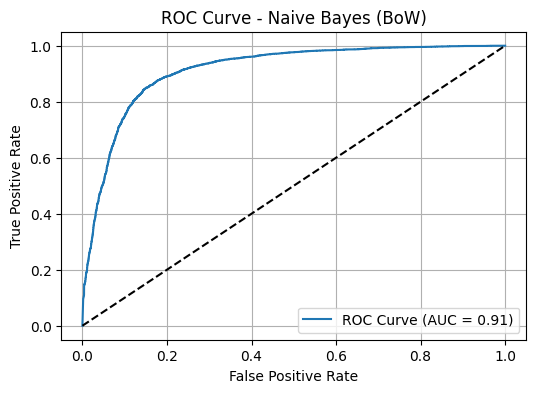

In [22]:
# تبدیل برچسب‌ها از رشته‌ای به عددی
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)  # negative → 0, positive → 1

# حالا محاسبه AUC و رسم منحنی ROC بدون خطا
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_binary, nb_cv.predict_proba(X_test_cv)[:,1])
auc_score = auc(fpr, tpr)

# رسم نمودار
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes (BoW)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# نقد جدید
new_review = ["I hated the movie. It was boring and too long."]


# پیش‌پردازش (همان روش قبلی)
# فرض کنیم vectorizer همون CountVectorizer هست که قبلاً fit شده
new_review_vectorized = vectorizer_cv.transform(new_review)

# پیش‌بینی با مدل Naive Bayes
prediction = nb_cv.predict(new_review_vectorized)

# نمایش نتیجه
print("Predicted sentiment:", prediction[0])


Predicted sentiment: positive


In [43]:
# نقد جدید
new_review = ["NOT BAD"]

# وکتوریزه کردن با TF-IDF vectorizer آموزش‌دیده
new_review_vectorized = vectorizer_tfidf.transform(new_review)

# پیش‌بینی با مدل Logistic Regression
prediction = lr_tfidf.predict(new_review_vectorized)

# اگر لیبل‌ها هنوز متنی هستن مثل "positive" و "negative":
print("Predicted sentiment:", prediction[0])


Predicted sentiment: negative
